In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df = pd.read_csv(r"C:\Users\prasa\OneDrive\Documents\KC\CODES 2024\project24\CSV_XLXS\Medicalpremium.csv")

In [3]:
#Summary Statistics
print(df.describe())

              Age    Diabetes  BloodPressureProblems  AnyTransplants  \
count  986.000000  986.000000             986.000000      986.000000   
mean    41.745436    0.419878               0.468560        0.055781   
std     13.963371    0.493789               0.499264        0.229615   
min     18.000000    0.000000               0.000000        0.000000   
25%     30.000000    0.000000               0.000000        0.000000   
50%     42.000000    0.000000               0.000000        0.000000   
75%     53.000000    1.000000               1.000000        0.000000   
max     66.000000    1.000000               1.000000        1.000000   

       AnyChronicDiseases      Height      Weight  KnownAllergies  \
count          986.000000  986.000000  986.000000      986.000000   
mean             0.180527  168.182556   76.950304        0.215010   
std              0.384821   10.098155   14.265096        0.411038   
min              0.000000  145.000000   51.000000        0.000000   
25%   

In [4]:
#Correlation Matrix
corr_matrix = df.corr()

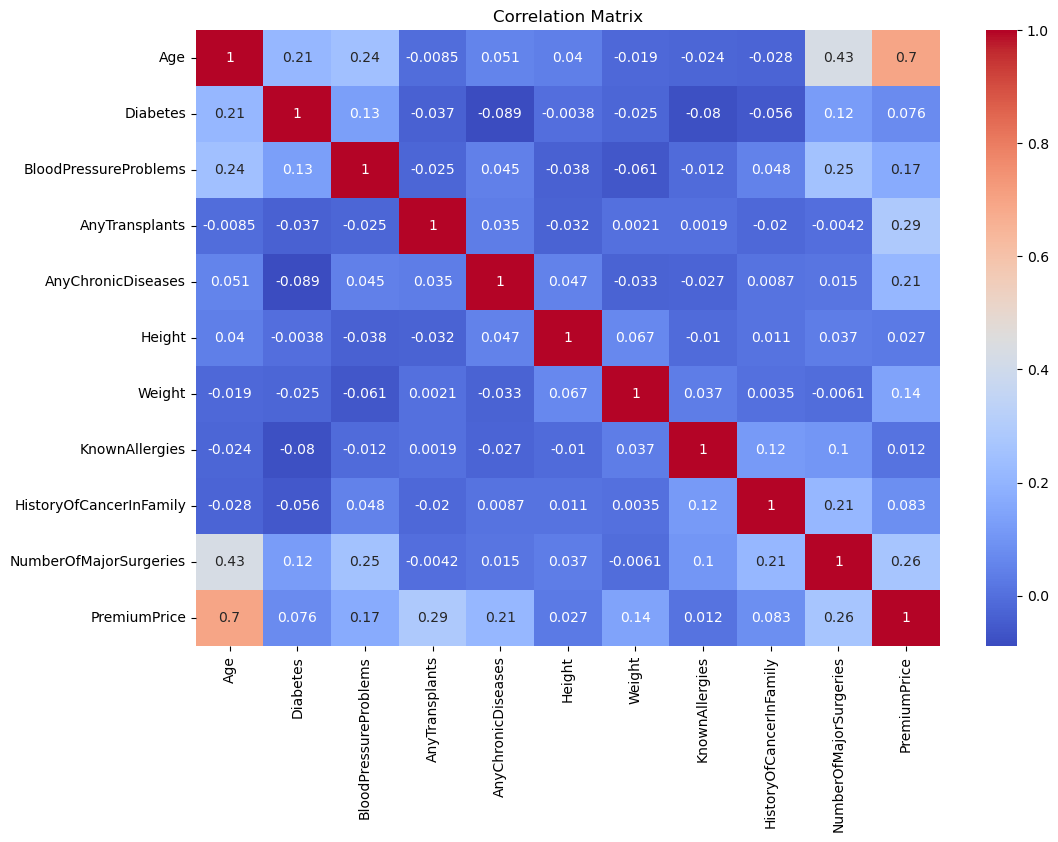

In [5]:
#Heatmap of the correlation matrix
plt.figure(figsize=(12,8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

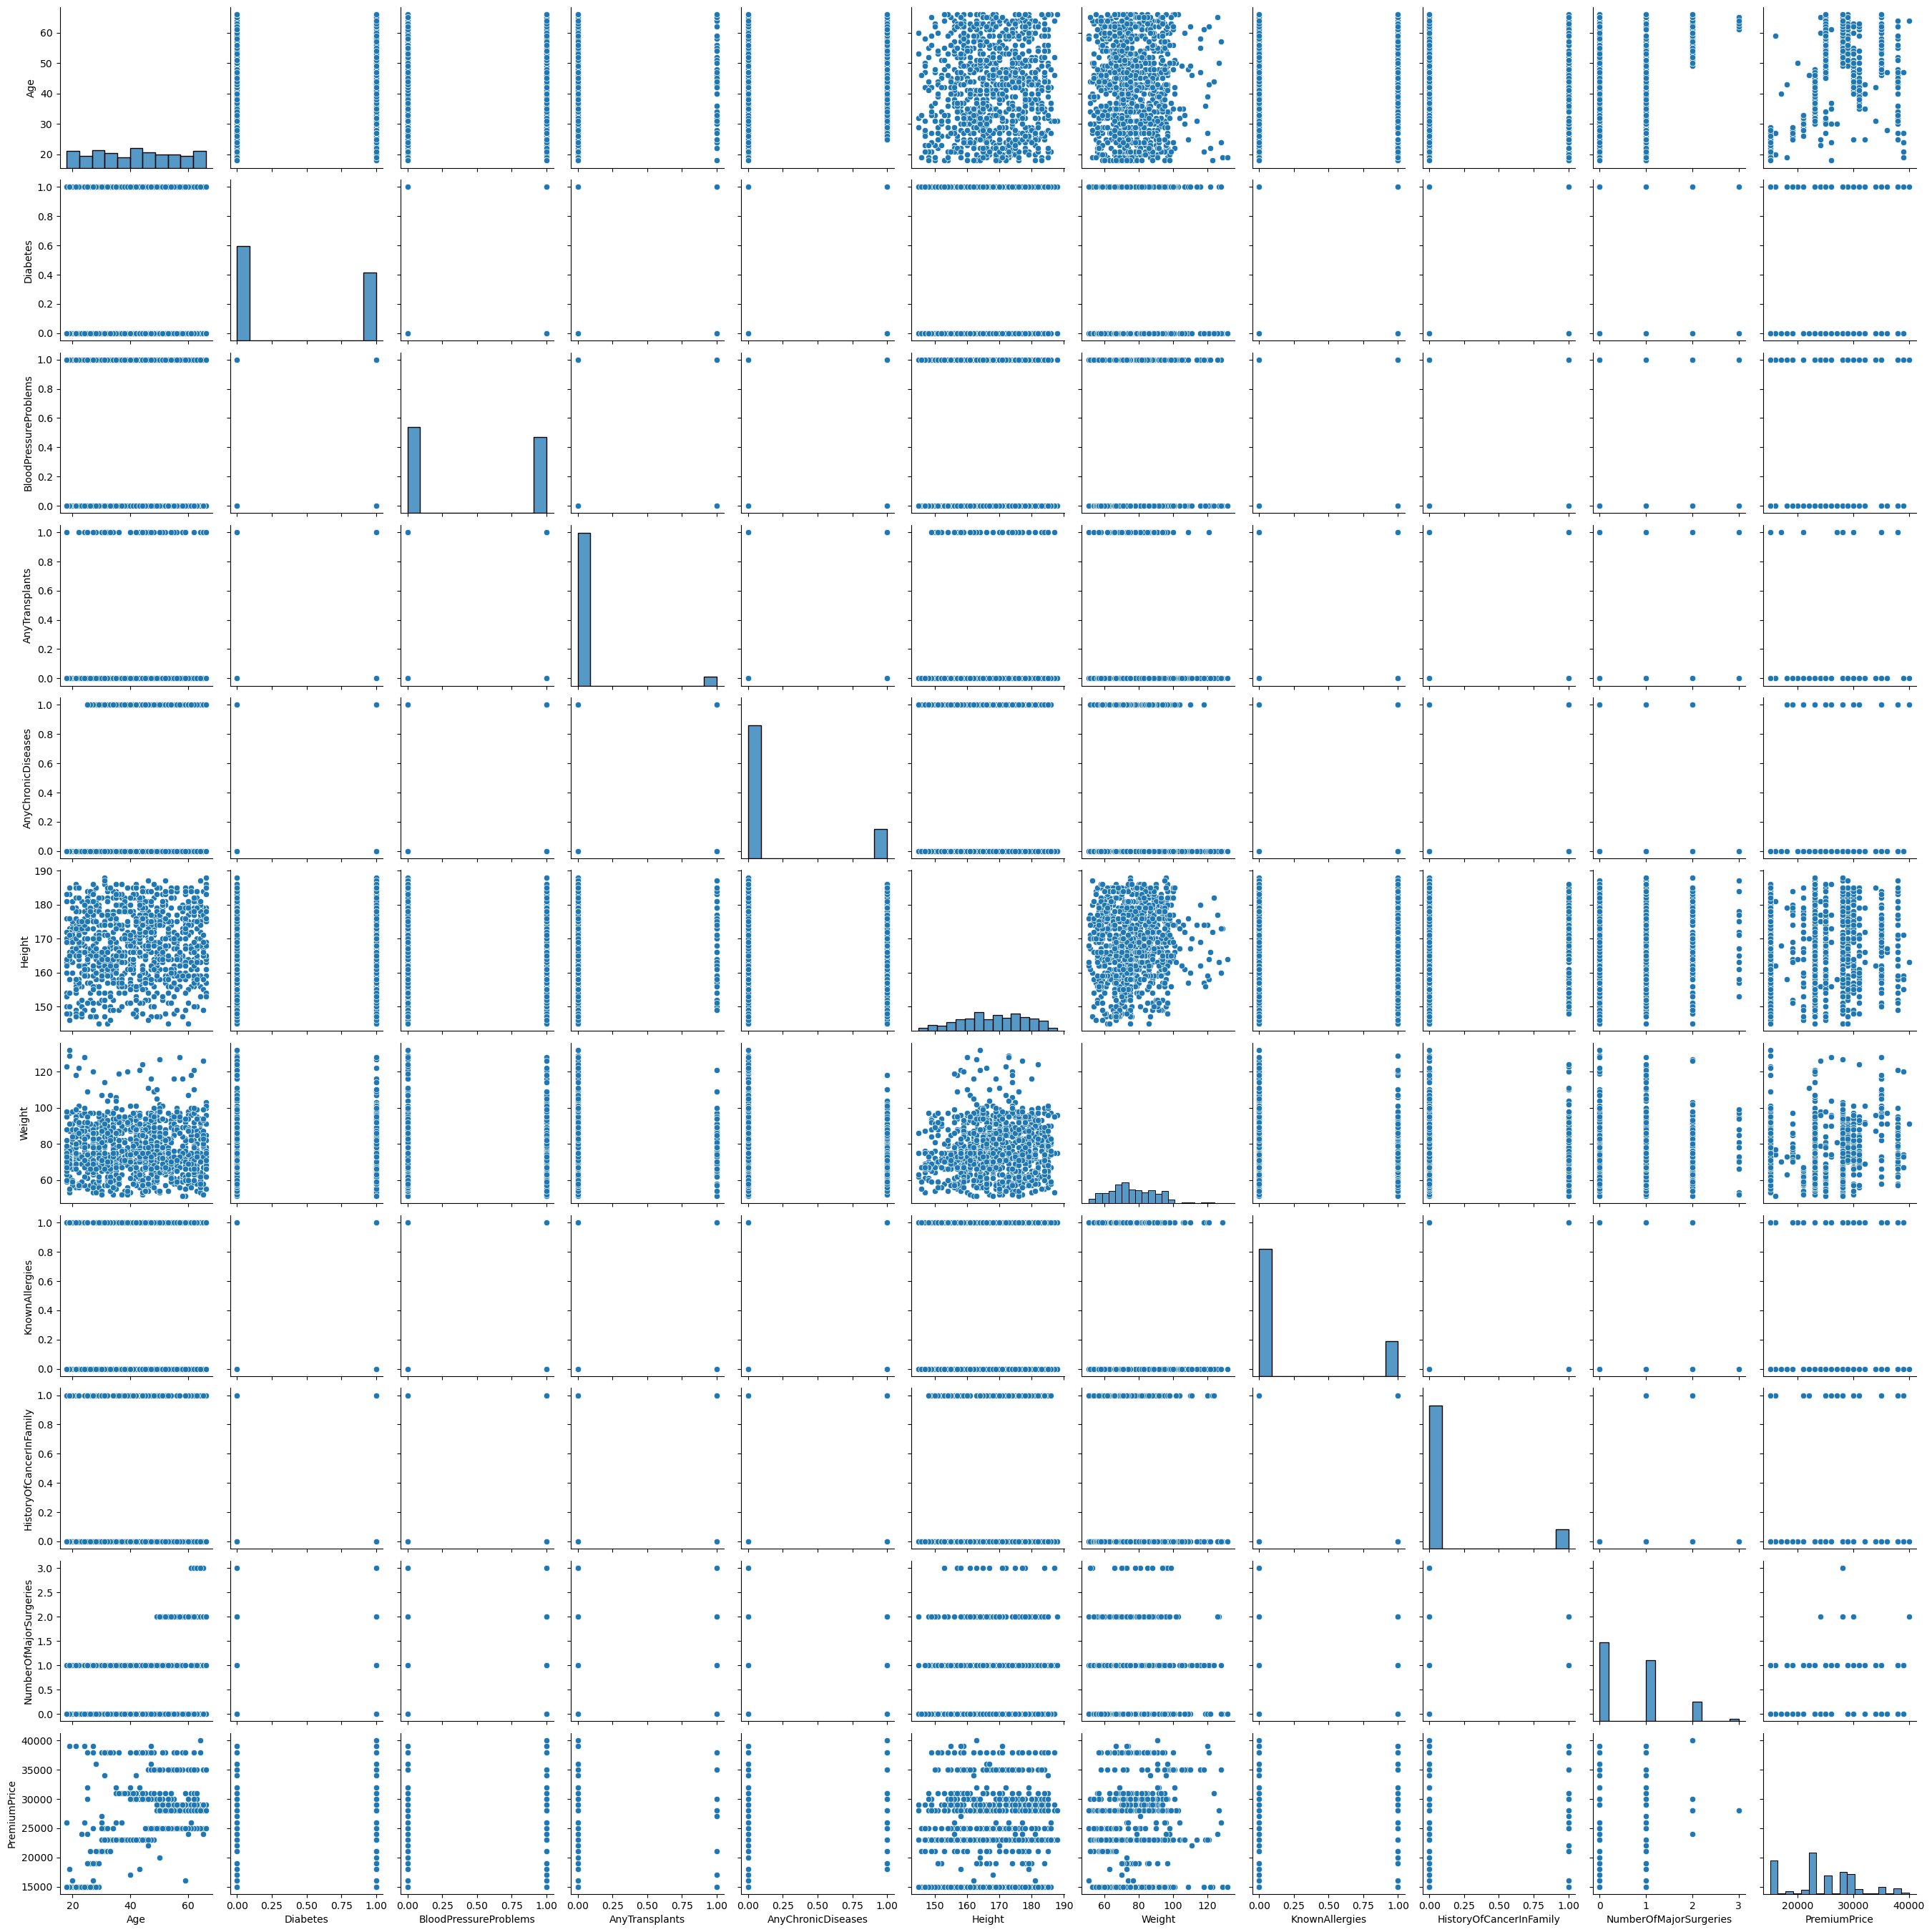

In [6]:
#Pairplot
sns.pairplot(df)
plt.show()

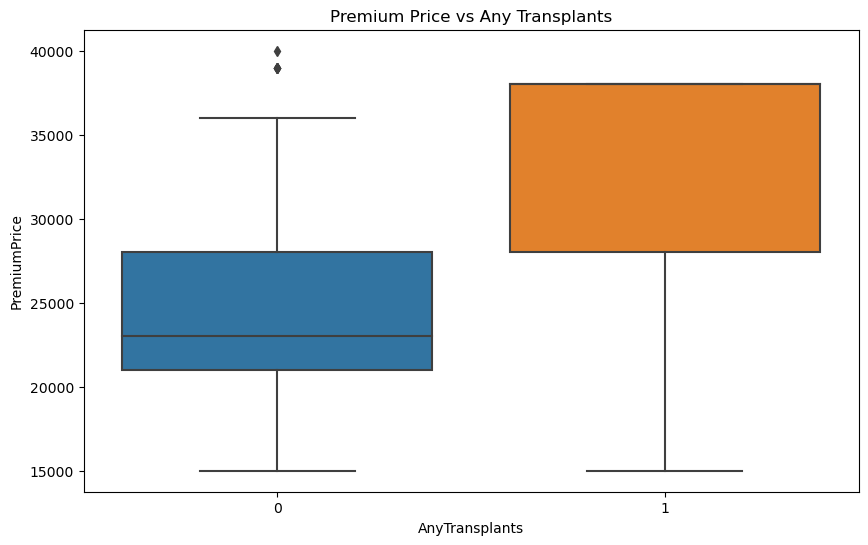

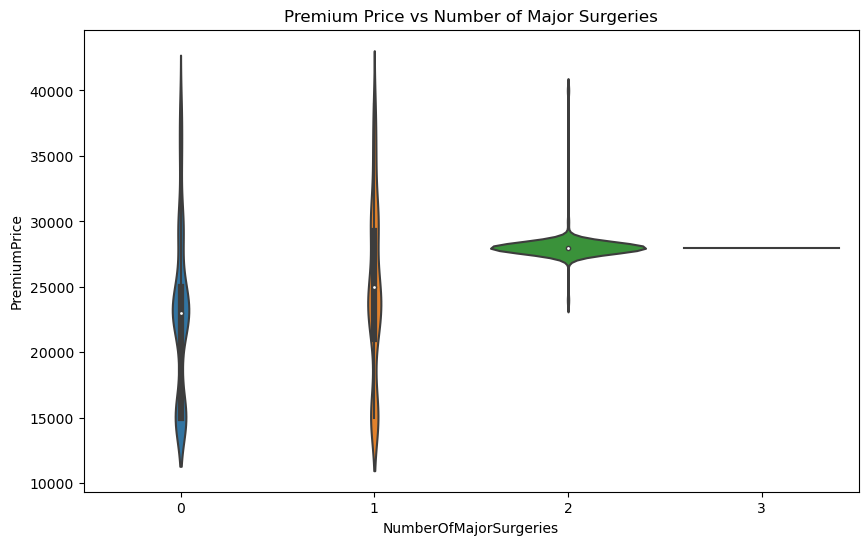

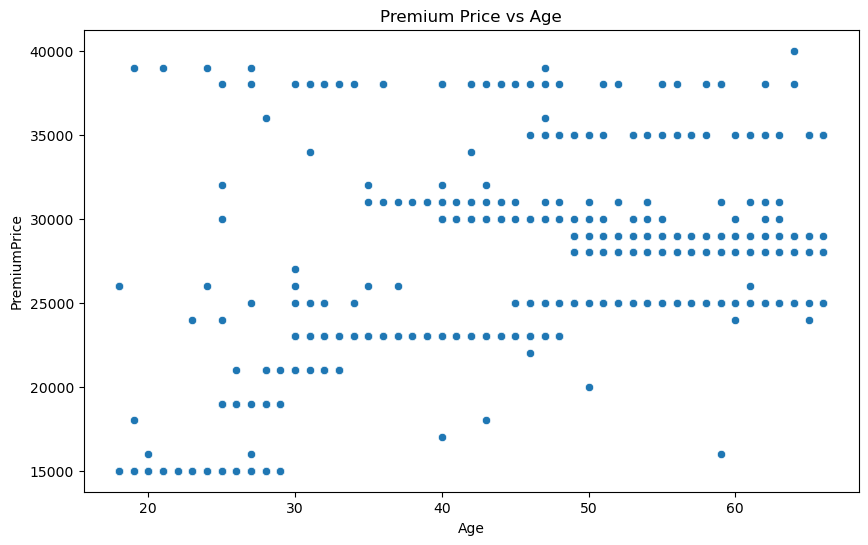

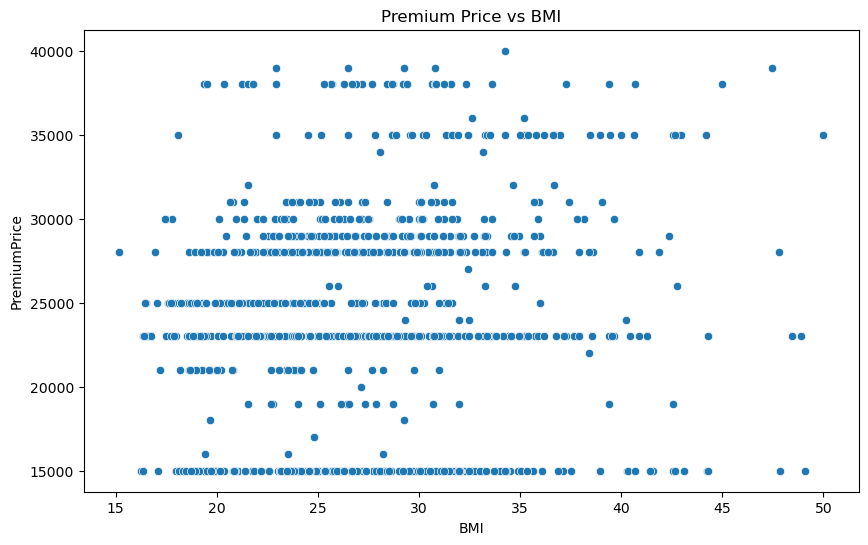

In [7]:
# Feature Engineering
df['BMI'] = df['Weight'] / (df['Height'] / 100) ** 2
df['AgeGroup'] = pd.cut(df['Age'], bins=[18, 30, 40, 50, 60, 70], labels=['18-30', '31-40', '41-50', '51-60', '61-70'])

# Visualizations
plt.figure(figsize=(10, 6))
sns.boxplot(x='AnyTransplants', y='PremiumPrice', data=df)
plt.title('Premium Price vs Any Transplants')
plt.show()

plt.figure(figsize=(10, 6))
sns.violinplot(x='NumberOfMajorSurgeries', y='PremiumPrice', data=df)
plt.title('Premium Price vs Number of Major Surgeries')
plt.show()

plt.figure(figsize=(10, 6))
sns.scatterplot(x='Age', y='PremiumPrice', data=df)
plt.title('Premium Price vs Age')
plt.show()

plt.figure(figsize=(10, 6))
sns.scatterplot(x='BMI', y='PremiumPrice', data=df)
plt.title('Premium Price vs BMI')
plt.show()

In [8]:
from scipy.stats import ttest_ind

# Compare premium prices between individuals with and without diabetes
diabetes_yes = df[df['Diabetes'] == 1]['PremiumPrice']
diabetes_no = df[df['Diabetes'] == 0]['PremiumPrice']

# Perform t-test
t_stat, p_val = ttest_ind(diabetes_yes, diabetes_no)
print(f"T-Statistic: {t_stat}, P-Value: {p_val}")


T-Statistic: 2.3975629574233563, P-Value: 0.01669009138530611


In [9]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

# Identify numerical and categorical columns
numerical_cols = ['Age', 'Height', 'Weight', 'BMI', 'NumberOfMajorSurgeries']
categorical_cols = ['Diabetes', 'BloodPressureProblems', 'AnyTransplants', 'AnyChronicDiseases', 'KnownAllergies', 'HistoryOfCancerInFamily', 'AgeGroup']

# Preprocessing pipeline for numerical data
numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

# Preprocessing pipeline for categorical data
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Combine preprocessing for numerical and categorical data
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols)
    ])

# Define the model
model = RandomForestRegressor(n_estimators=100, random_state=42)

# Create and evaluate the pipeline
clf = Pipeline(steps=[('preprocessor', preprocessor),
                      ('model', model)])

# Split data into training and testing sets
X = df.drop(['PremiumPrice'], axis=1)
y = df['PremiumPrice']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train the model
clf.fit(X_train, y_train)

# Predict on test data
y_pred = clf.predict(X_test)

# Evaluate the model
print('Random Forest RMSE:', mean_squared_error(y_test, y_pred, squared=False))
print('Random Forest R²:', r2_score(y_test, y_pred))

# Repeat for Linear Regression
model_lr = LinearRegression()
clf_lr = Pipeline(steps=[('preprocessor', preprocessor),
                         ('model', model_lr)])
clf_lr.fit(X_train, y_train)
y_pred_lr = clf_lr.predict(X_test)
print('Linear Regression RMSE:', mean_squared_error(y_test, y_pred_lr, squared=False))
print('Linear Regression R²:', r2_score(y_test, y_pred_lr))


Random Forest RMSE: 2124.9745096510374
Random Forest R²: 0.894108324001895
Linear Regression RMSE: 3049.3431848089076
Linear Regression R²: 0.7819445322329033


In [11]:
from sklearn.model_selection import GridSearchCV, cross_val_score
import shap
import pandas as pd

# Hyperparameter tuning
param_grid = {
    'model__n_estimators': [100, 200, 300],
    'model__max_depth': [None, 10, 20, 30],
    'model__min_samples_split': [2, 5, 10],
    'model__min_samples_leaf': [1, 2, 4]
}

grid_search = GridSearchCV(clf, param_grid, cv=5, scoring='neg_mean_squared_error')
grid_search.fit(X_train, y_train)
print("Best parameters found: ", grid_search.best_params_)
best_model = grid_search.best_estimator_

# Cross-validation
cv_scores = cross_val_score(best_model, X, y, cv=5, scoring='neg_mean_squared_error')
print("Cross-validated RMSE: ", (-cv_scores.mean())**0.5)

# Feature importance
importances = best_model.named_steps['model'].feature_importances_
feature_names = numerical_cols + list(best_model.named_steps['preprocessor'].transformers_[1][1]['onehot'].get_feature_names(categorical_cols))
feature_importance_df = pd.DataFrame({'feature': feature_names, 'importance': importances})
feature_importance_df.sort_values(by='importance', ascending=False, inplace=True)
print(feature_importance_df)

# SHAP values
#explainer = shap.TreeExplainer(best_model.named_steps['model'])
#shap_values = explainer.shap_values(X_test)
#shap.summary_plot(shap_values, X_test, feature_names=feature_names)


Best parameters found:  {'model__max_depth': None, 'model__min_samples_leaf': 2, 'model__min_samples_split': 10, 'model__n_estimators': 200}
Cross-validated RMSE:  2823.192272850072
                      feature  importance
0                         Age    0.675127
2                      Weight    0.072522
9            AnyTransplants_0    0.052392
10           AnyTransplants_1    0.051064
4      NumberOfMajorSurgeries    0.031477
3                         BMI    0.030246
12       AnyChronicDiseases_1    0.019860
11       AnyChronicDiseases_0    0.019807
1                      Height    0.016632
16  HistoryOfCancerInFamily_1    0.011197
15  HistoryOfCancerInFamily_0    0.010780
8     BloodPressureProblems_1    0.003209
7     BloodPressureProblems_0    0.002562
19             AgeGroup_41-50    0.000939
6                  Diabetes_1    0.000605
5                  Diabetes_0    0.000428
14           KnownAllergies_1    0.000314
18             AgeGroup_31-40    0.000248
17             AgeGr

C:\Users\prasa\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
